In [1]:
import wandb
import time
import torch
import os
import numpy as np
from dataclasses import dataclass
from datetime import datetime
from typing import Dict, Optional, List, Tuple
import psutil
from collections import defaultdict
import matplotlib.pyplot as plt
from environment import create_env, SimulationSettings
from ppo import PPOAgent, PPOConfig


In [4]:
@dataclass
class Args:
    exp_name: str = "combustion_ppo_1d"
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = False
    track: bool = False
    wandb_project_name: str = "combustion_control_1d"
    wandb_entity: str = None
    
    # Environment Parameters
    output_dir: str = 'run/rl_train'
    t_end: float = 0.06
    n_points: int = 50
    global_timestep: float = 1e-5
    
    # Algorithm specific arguments
    total_timesteps: int = 100000
    learning_rate: float = 2.5e-3
    num_envs: int = 1
    num_steps: int = 80
    gamma: float = 0.99
    gae_lambda: float = 0.95
    num_minibatches: int = 16
    update_epochs: int = 10
    eps_clip: float = 0.2
    entropy_coef: float = 0.01
    value_loss_coef: float = 0.5
    max_grad_norm: float = 0.5
    
    save_step_data: bool = False
    
    # Features configuration
    features_config: dict = None
    reward_config: dict = None

def make_env(args):
    """Create environment with specified settings"""
    sim_settings = SimulationSettings(
        output_dir=args.output_dir,
        t_end=args.t_end,
        n_points=args.n_points,
        global_timestep=args.global_timestep
    )
    
    env = create_env(
        sim_settings=sim_settings,
        benchmark_file="env_benchmark_n.h5",
        species_to_track=['CH4', 'O2', 'CO2', 'H2O'],
        features_config=args.features_config,
        reward_config=args.reward_config,
        save_step_data=args.save_step_data
    )
    return env


def set_integrator_heuristic(solver, fixed_integrator: str = None) -> List[str]:
    """Set integrator type based on temperature and equivalence ratio"""
    nPoints = len(solver.T)
    
    if fixed_integrator is not None:
        return [fixed_integrator] * nPoints
    
    # Start with temperature-based decision
    integ = np.where(solver.T <= 600.0, 'boostRK', 'cvode')
        
    try:
        # Get equivalence ratio
        phi = solver.phi
        
        # Use boostRK for extreme conditions
        integ = np.where(phi == -1, 'boostRK', integ)  # invalid phi
        integ = np.where(phi <= 1e-8, 'boostRK', integ)  # oxidizer-dominated
        integ = np.where(phi >= 1e4, 'boostRK', integ)   # fuel-dominated
        
        # Create boolean mask for CVODE points
        cvode_mask = (integ == 'cvode')
        
        # Include neighboring points
        cvode_mask_left = np.roll(cvode_mask, 1)
        cvode_mask_right = np.roll(cvode_mask, -1)
        cvode_mask_left[0] = False
        cvode_mask_right[-1] = False
        
        use_cvode = cvode_mask | cvode_mask_left | cvode_mask_right
        integ = np.where(use_cvode, 'cvode', 'boostRK')
    except Exception as e:
        print(f"Warning: Could not calculate phi for integrator selection: {e}")
    
    return integ.tolist()

def integrator_to_action(integrators: List[str]) -> List[int]:
    """Convert integrator to action"""
    return [int(integrator == 'boostRK') for integrator in integrators]


In [5]:

# # Environment setup
# reward_config = {
#             'weights': {
#                 'accuracy': 0.6,
#                 'efficiency': 0.3,
#                 'stability': 0.1
#             },
#             'thresholds': {
#                 'time': 0.005,
#                 'error': 1,
#                 'stability': 100
#             },
#             'scaling': {
#                 'time': 5,
#                 'error': 10,
#                 'stability': 0.0,
#                 'factor': 0.1
#             }
#             }

reward_config = {
            'weights': {
                'accuracy': 1,
                'efficiency': 3,
                'stability': 0.1
            },
            'thresholds': {
                'time': 0.001,
                'error': 1,
                'stability': 100
            },
            'scaling': {
                'time': 5,
                'error': 10,
                'stability': 0.1
            },
            'use_neighbors': True,
            'neighbor_weight': 0.3,
            'neighbor_radius': 4
        }

args = Args(reward_config=reward_config)
env = make_env(args)

# PPO agent setup
state_dim = env.observation_space.shape[1]
action_dim = len(env.integrator_options)

# ppo_agent = PPO(
#     state_dim=state_dim,
#     action_dim=action_dim,
#     lr_actor=args.learning_rate,
#     lr_critic=args.learning_rate,
#     gamma=args.gamma,
#     K_epochs=args.update_epochs,
#     eps_clip=args.eps_clip,
#     has_continuous_action_space=False
# )

# Initialize environment
obs, _ = env.reset(seed=args.seed)

jm = 24
Writing output file: run/rl_train/prof000000.h5
jm = 24
Writing output file: run/rl_train/prof000000.h5


In [6]:
env.solver.gridPointIntegrationTimes

array([0.001195, 0.000295, 0.000288, 0.000288, 0.000285, 0.000285,
       0.000283, 0.000285, 0.000284, 0.00033 , 0.000321, 0.000301,
       0.000288, 0.000288, 0.000285, 0.000289, 0.000287, 0.000297,
       0.000302, 0.000292, 0.000298, 0.000299, 0.000288, 0.000291,
       0.000286, 0.001197, 0.000296, 0.00029 , 0.000289, 0.000291,
       0.000287, 0.000285, 0.000287, 0.000288, 0.000312, 0.00035 ,
       0.000295, 0.000285, 0.000285, 0.000283, 0.000283, 0.000285,
       0.00029 , 0.00029 , 0.000285, 0.000292, 0.00029 , 0.000281,
       0.000284, 0.000282])

In [66]:
action = integrator_to_action(set_integrator_heuristic(env.solver, fixed_integrator='BoostRK'))
obs, rewards, terminated, truncated, info = env.step(action)



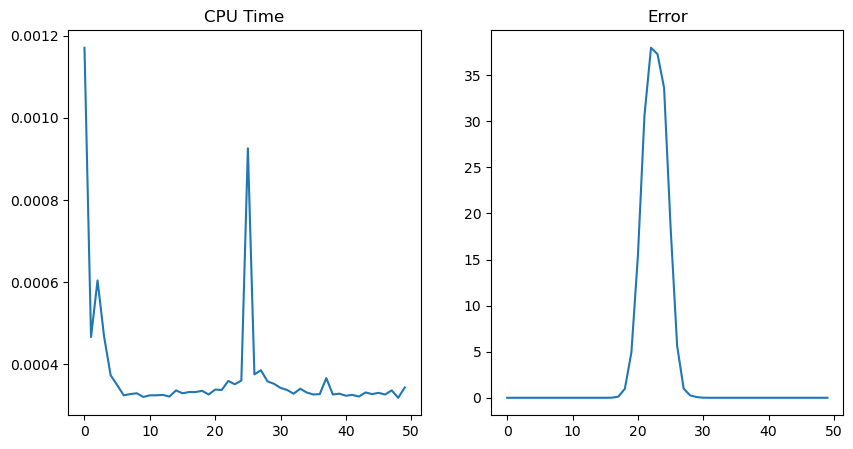

In [67]:
errors = info['point_errors']
cpu_times = env.solver.gridPointIntegrationTimes

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(cpu_times)
ax[1].plot(errors)

ax[0].set_title('CPU Time')
ax[1].set_title('Error')
plt.show()


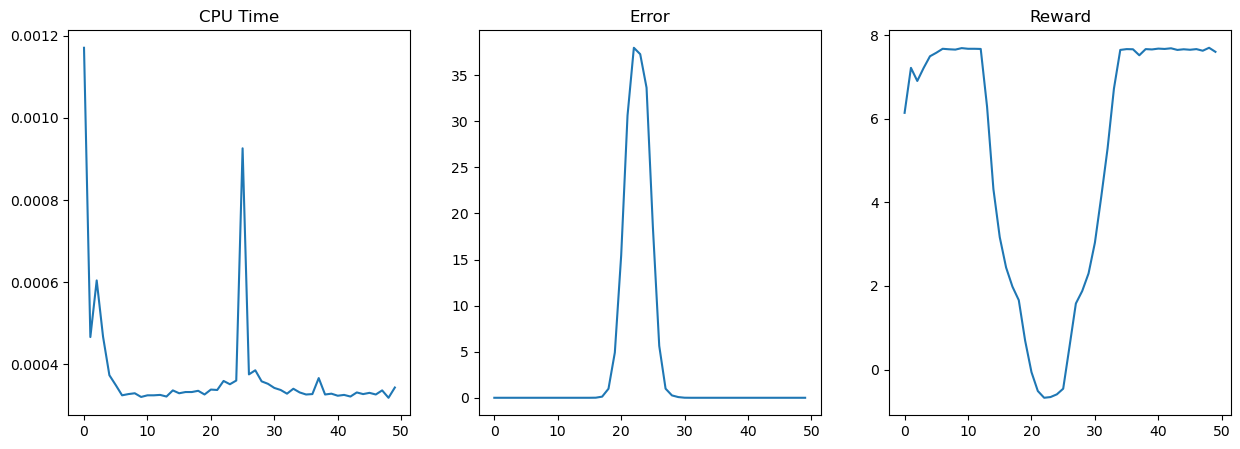

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(env.solver.gridPointIntegrationTimes)
ax[1].plot(info['point_errors'])
ax[2].plot(rewards)
ax[0].set_title('CPU Time')
ax[1].set_title('Error')
ax[2].set_title('Reward')
plt.show()


In [69]:
def run_episode(integrator = None):
    obs, _ = env.reset()
    done = False
    episode_length = 0
    episode_actions = []
    global_step = 0
    episode_rewards = []
    episode_errors = []
    episode_lengths = []
    episode_cpu_times = []
    use_rl = False
    while not done:
        # # Get actions for all points
        # if use_rl:
        #     actions = []
        #     for point_obs in obs:
        #         action = ppo_agent.select_action(point_obs, deterministic=True, store_in_buffer=False)
        #         actions.append(action)
        #     actions = np.array(actions)
        # else:
        integrator_actions = integrator_to_action(set_integrator_heuristic(env.solver, fixed_integrator=integrator))
        actions = integrator_actions
        episode_actions.append(actions)
        
        if global_step % 100 == 0:
            print(f"[EvalSTEP {global_step}] Action Distribution: {np.bincount(actions) / len(actions)}")
        
        obs, rewards, terminated, truncated, info = env.step(actions)
        done = terminated or truncated
        
        episode_rewards.append(rewards)
        episode_errors.append(info['point_errors'])
        episode_cpu_times.append(info['cpu_time'])
        episode_length += 1
        global_step += 1

    return episode_rewards, episode_errors, episode_cpu_times, episode_lengths
    

In [70]:
integrators = ['boostRK', 'CVODE', 'Heurs']
for integrator in integrators:
    if integrator == 'Heurs':
        integrator = None
    episode_rewards, episode_errors, episode_cpu_times, episode_lengths = run_episode(integrator)
    
    if integrator == 'boostRK':
        rk_rewards = episode_rewards
        rk_errors = episode_errors
        rk_lengths = episode_lengths
        rk_cpu_times = episode_cpu_times
    elif integrator == 'CVODE':
        cvode_rewards = episode_rewards
        cvode_errors = episode_errors
        cvode_lengths = episode_lengths
        cvode_cpu_times = episode_cpu_times
    else:
        heurs_rewards = episode_rewards
        heurs_errors = episode_errors
        heurs_lengths = episode_lengths
        heurs_cpu_times = episode_cpu_times


jm = 24
Writing output file: run/rl_train/prof000000.h5
[EvalSTEP 0] Action Distribution: [0. 1.]


/Users/elotech/.local/share/mamba/envs/ember-build1/lib/python3.12/site-packages/ember/input.py:1283: RuntimeWarning: divide by zero encountered in scalar divide
  scale = 0.8 * (x[-1] - x[0]) / (IC.centerWidth + 2 * IC.slopeWidth)


[EvalSTEP 100] Action Distribution: [0. 1.]
[EvalSTEP 200] Action Distribution: [0. 1.]
[EvalSTEP 300] Action Distribution: [0. 1.]
[EvalSTEP 400] Action Distribution: [0. 1.]
[EvalSTEP 500] Action Distribution: [0. 1.]
[EvalSTEP 600] Action Distribution: [0. 1.]
[EvalSTEP 700] Action Distribution: [0. 1.]
[EvalSTEP 800] Action Distribution: [0. 1.]
[EvalSTEP 900] Action Distribution: [0. 1.]
[EvalSTEP 1000] Action Distribution: [0. 1.]
[EvalSTEP 1100] Action Distribution: [0. 1.]
[EvalSTEP 1200] Action Distribution: [0. 1.]
[EvalSTEP 1300] Action Distribution: [0. 1.]
[EvalSTEP 1400] Action Distribution: [0. 1.]
[EvalSTEP 1500] Action Distribution: [0. 1.]
[EvalSTEP 1600] Action Distribution: [0. 1.]
[EvalSTEP 1700] Action Distribution: [0. 1.]
[EvalSTEP 1800] Action Distribution: [0. 1.]
[EvalSTEP 1900] Action Distribution: [0. 1.]
[EvalSTEP 2000] Action Distribution: [0. 1.]
[EvalSTEP 2100] Action Distribution: [0. 1.]
[EvalSTEP 2200] Action Distribution: [0. 1.]
[EvalSTEP 2300] Act

Sum of rk rewards at 100: -18.119886853430074
Sum of cvode rewards at 100: 359.30710465961585
Sum of heurs rewards at 100: 474.6965529681298
Sum of rk errors at 100: 802.1147231269427
Sum of cvode errors at 100: 0.24077398499786967
Sum of heurs errors at 100: 0.525591523645049


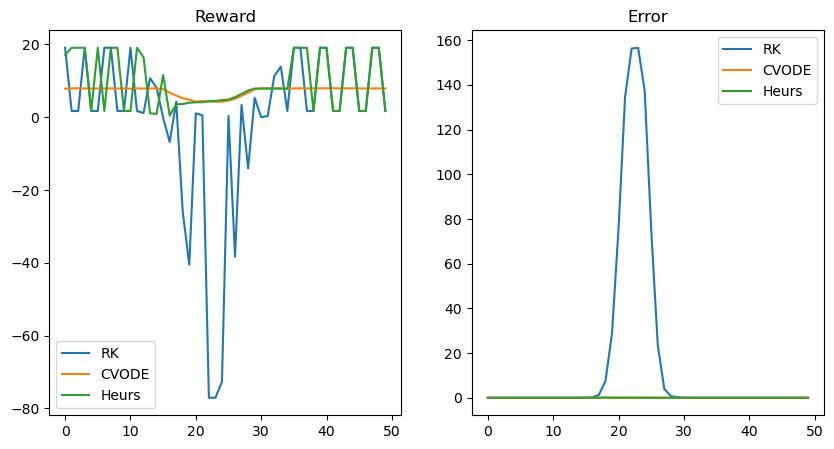

In [71]:
time_step = 100
print(f"Sum of rk rewards at {time_step}: {np.sum(rk_rewards[time_step])}")
print(f"Sum of cvode rewards at {time_step}: {np.sum(cvode_rewards[time_step])}")
print(f"Sum of heurs rewards at {time_step}: {np.sum(heurs_rewards[time_step])}")

print(f"Sum of rk errors at {time_step}: {np.sum(rk_errors[time_step])}")
print(f"Sum of cvode errors at {time_step}: {np.sum(cvode_errors[time_step])}")
print(f"Sum of heurs errors at {time_step}: {np.sum(heurs_errors[time_step])}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rk_rewards[time_step] - np.maximum(0, np.log10(np.maximum(rk_errors[time_step], 1e-10))) * 0, label='RK')
ax[0].plot(cvode_rewards[time_step] - np.maximum(0, np.log10(np.maximum(cvode_errors[time_step], 1e-10))) * 0, label='CVODE')
ax[0].plot(heurs_rewards[time_step] - np.maximum(0, np.log10(np.maximum(heurs_errors[time_step], 1e-10))) * 0, label='Heurs')
ax[1].plot(rk_errors[time_step], label='RK')
ax[1].plot(cvode_errors[time_step], label='CVODE')
ax[1].plot(heurs_errors[time_step], label='Heurs')
# ax[2].plot(env.solver.T, label='True')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Reward')
ax[1].set_title('Error')
plt.show()

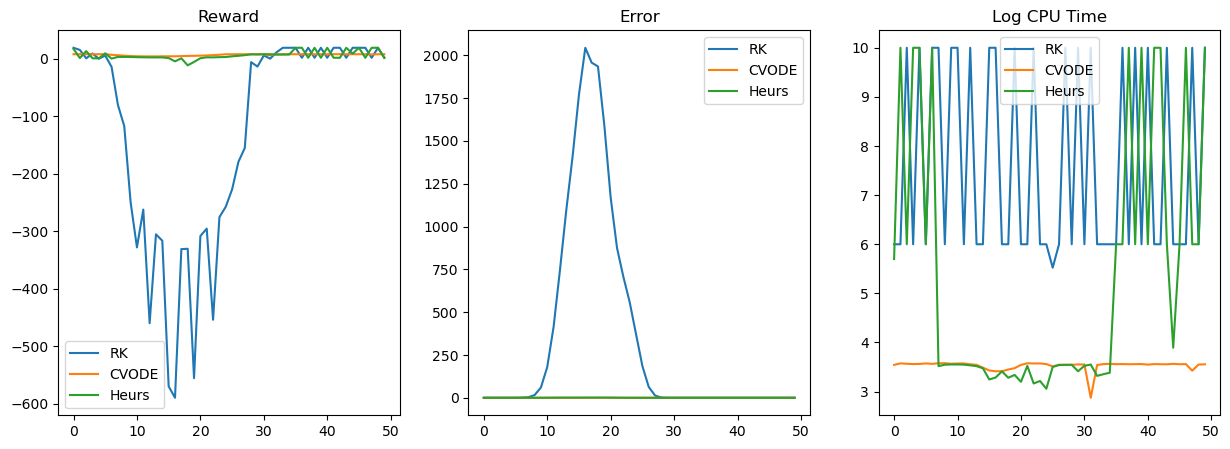

In [78]:
time_step = -1
rk_err = rk_errors[time_step]
cvode_err = cvode_errors[time_step]
heurs_err = heurs_errors[time_step]


rk_t = rk_cpu_times[time_step]
cvode_t = cvode_cpu_times[time_step]
heurs_t = heurs_cpu_times[time_step]

rk_r = rk_rewards[time_step]
cvode_r = cvode_rewards[time_step]
heurs_r = heurs_rewards[time_step]



fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(rk_r, label='RK')
ax[0].plot(cvode_r, label='CVODE')
ax[0].plot(heurs_r, label='Heurs')
ax[0].legend()
ax[0].set_title('Reward')
ax[1].plot(rk_err, label='RK')
ax[1].plot(cvode_err, label='CVODE')
ax[1].plot(heurs_err, label='Heurs')
ax[1].legend()
ax[1].set_title('Error')
ax[2].plot(-np.log10(np.maximum(rk_t, 1e-10)), label='RK')
ax[2].plot(-np.log10(np.maximum(cvode_t, 1e-10)), label='CVODE')
ax[2].plot(-np.log10(np.maximum(heurs_t, 1e-10)), label='Heurs')
ax[2].legend()
ax[2].set_title('Log CPU Time')
plt.show()


Sum of rk rewards at 5000: 5.486274223970032
Sum of cvode rewards at 5000: 60.50748730264976
Sum of heurs rewards at 5000: 66.31033625100991
Sum of rk errors at 5000: 17063.99665159564
Sum of cvode errors at 5000: 0.9878173648740862
Sum of heurs errors at 5000: 4.326412703606117


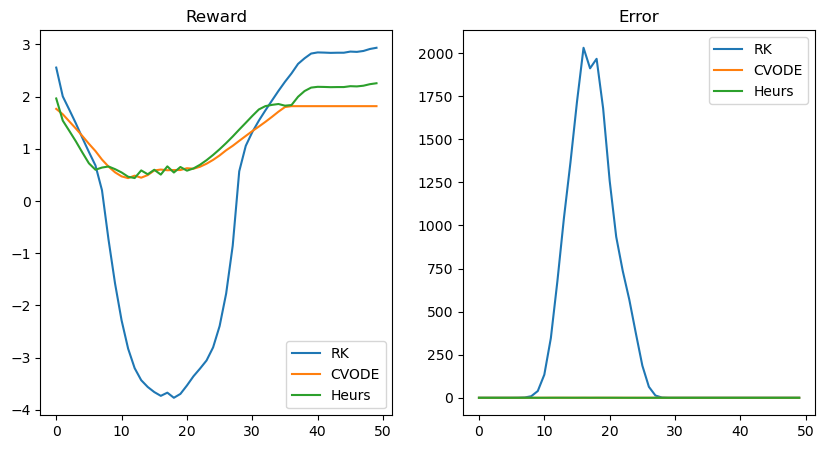

In [38]:
time_step = 5000
print(f"Sum of rk rewards at {time_step}: {np.sum(rk_rewards[time_step] - np.maximum(0, np.log10(rk_errors[time_step])))}")
print(f"Sum of cvode rewards at {time_step}: {np.sum(cvode_rewards[time_step] - np.maximum(0, np.log10(cvode_errors[time_step])))}")
print(f"Sum of heurs rewards at {time_step}: {np.sum(heurs_rewards[time_step] - np.maximum(0, np.log10(heurs_errors[time_step])))}")

print(f"Sum of rk errors at {time_step}: {np.sum(rk_errors[time_step])}")
print(f"Sum of cvode errors at {time_step}: {np.sum(cvode_errors[time_step])}")
print(f"Sum of heurs errors at {time_step}: {np.sum(heurs_errors[time_step])}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rk_rewards[time_step] - np.maximum(0, np.log10(rk_errors[time_step])), label='RK')
ax[0].plot(cvode_rewards[time_step] - np.maximum(0, np.log10(cvode_errors[time_step])), label='CVODE')
ax[0].plot(heurs_rewards[time_step] - np.maximum(0, np.log10(heurs_errors[time_step])), label='Heurs')
ax[1].plot(rk_errors[time_step], label='RK')
ax[1].plot(cvode_errors[time_step], label='CVODE')
ax[1].plot(heurs_errors[time_step], label='Heurs')
# ax[2].plot(env.solver.T, label='True')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Reward')
ax[1].set_title('Error')
plt.show()

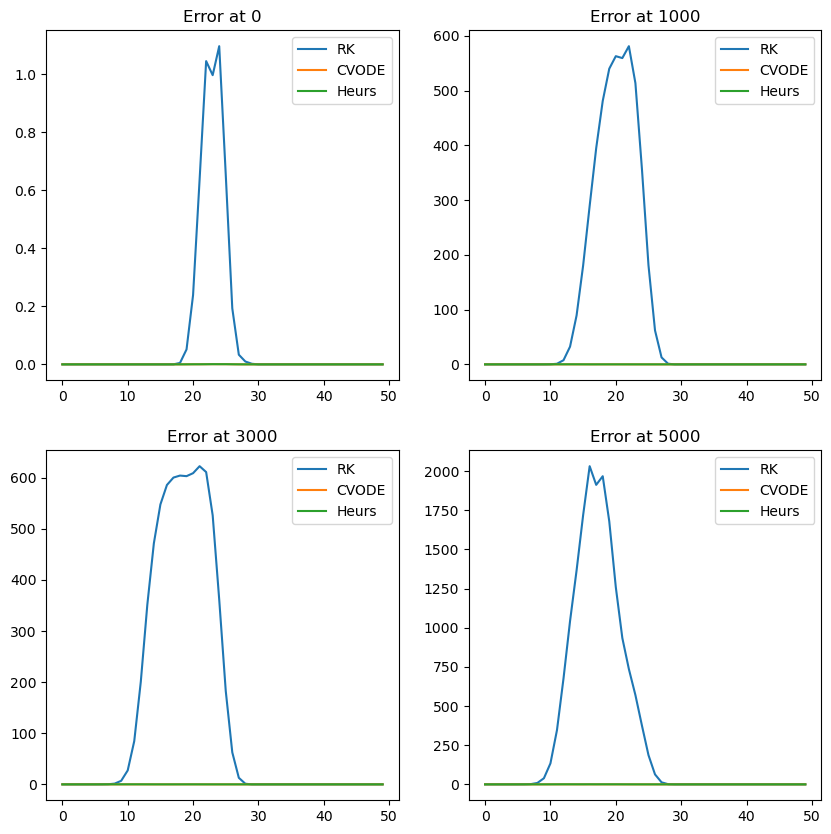

In [20]:
# plot the error in the 0, 1000, 3000, 5000 time steps in a 2 x 2 grid
time_steps = [0, 1000, 3000, 5000]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, time_step in enumerate(time_steps):
    ax[i//2, i%2].plot(rk_errors[time_step], label='RK')
    ax[i//2, i%2].plot(cvode_errors[time_step], label='CVODE')
    ax[i//2, i%2].plot(heurs_errors[time_step], label='Heurs')
    ax[i//2, i%2].set_title(f'Error at {time_step}')
    ax[i//2, i%2].legend()
plt.show()


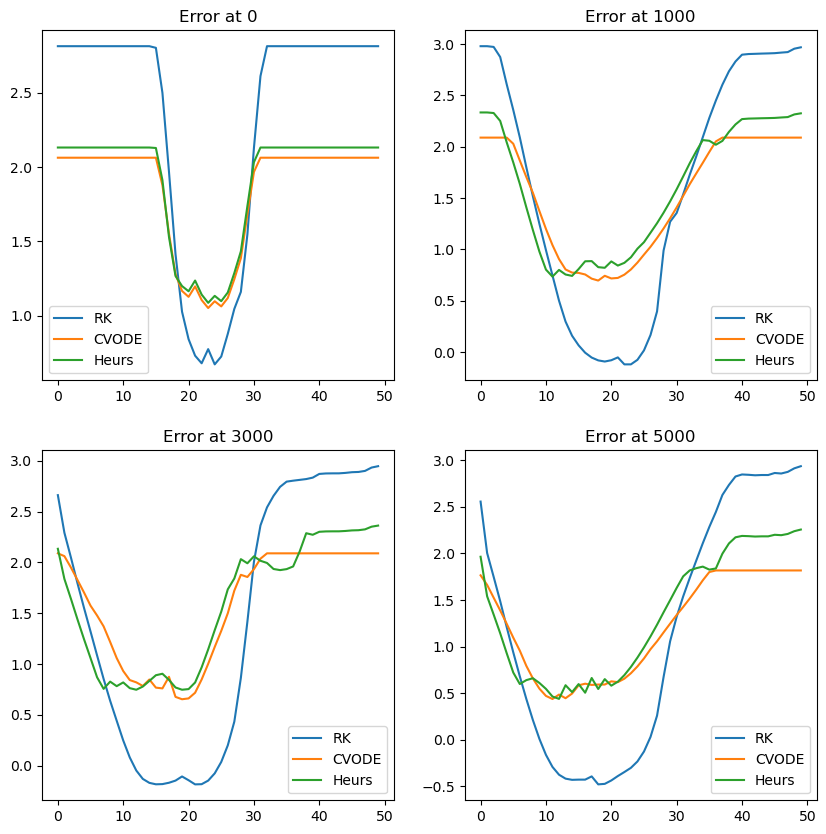

In [21]:
# plot the reward in the 0, 1000, 3000, 5000 time steps in a 2 x 2 grid 
time_steps = [0, 1000, 3000, 5000]
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i, time_step in enumerate(time_steps):
    ax[i//2, i%2].plot(rk_rewards[time_step], label='RK')
    ax[i//2, i%2].plot(cvode_rewards[time_step], label='CVODE')
    ax[i//2, i%2].plot(heurs_rewards[time_step], label='Heurs')
    ax[i//2, i%2].set_title(f'Error at {time_step}')
    ax[i//2, i%2].legend()
plt.show()


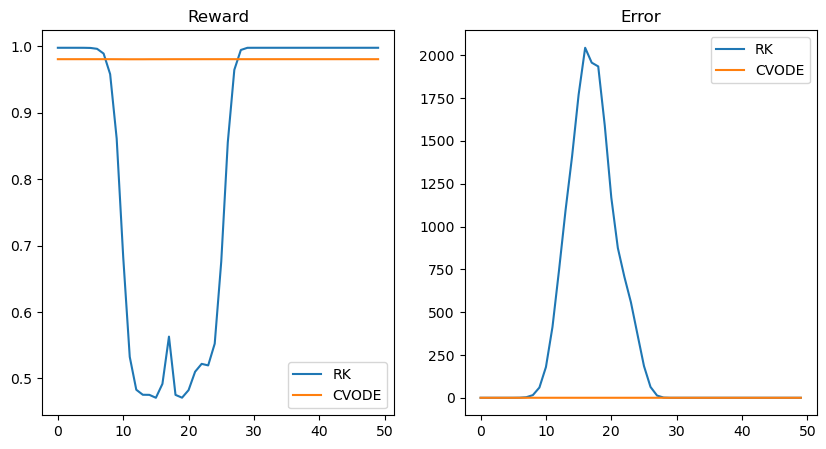

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rk_rewards[-1], label='RK')
ax[0].plot(cvode_rewards[-1], label='CVODE')
# ax[0].plot(heurs_rewards[-1], label='Heurs')
ax[1].plot(rk_errors[-1], label='RK')
ax[1].plot(cvode_errors[-1], label='CVODE')
# ax[1].plot(heurs_errors[-1000], label='Heurs')
# ax[2].plot(env.solver.T, label='True')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Reward')
ax[1].set_title('Error')
plt.show()

In [ ]:
print(f"RK: Min: {rk_cpu_times.min()}, Max: {rk_cpu_times.max()}, Mean: {rk_cpu_times.mean()}, Std: {rk_cpu_times.std()}")
print(f"Heurs: Min: {heurs_cpu_times.min()}, Max: {heurs_cpu_times.max()}, Mean: {heurs_cpu_times.mean()}, Std: {heurs_cpu_times.std()}")
print(f"CVODE: Min: {cvode_cpu_times.min()}, Max: {cvode_cpu_times.max()}, Mean: {cvode_cpu_times.mean()}, Std: {cvode_cpu_times.std()}")


In [ ]:
rk_errors = np.array(rk_errors)
heurs_errors = np.array(heurs_errors)
cvode_errors = np.array(cvode_errors)

print(f"RK: Min: {rk_errors.min()}, Max: {rk_errors.max()}, Mean: {rk_errors.mean()}, Std: {rk_errors.std()}")
print(f"Heurs: Min: {heurs_errors.min()}, Max: {heurs_errors.max()}, Mean: {heurs_errors.mean()}, Std: {heurs_errors.std()}")
print(f"CVODE: Min: {cvode_errors.min()}, Max: {cvode_errors.max()}, Mean: {cvode_errors.mean()}, Std: {cvode_errors.std()}")


In [ ]:
print(heurs_cpu_times.min())
print(heurs_cpu_times.max())
print(heurs_cpu_times.mean())
print(heurs_cpu_times.std())

print("--------------------------------")

print(cvode_cpu_times.min())
print(cvode_cpu_times.max())
print(cvode_cpu_times.mean())
print(cvode_cpu_times.std())


In [ ]:
rk_cpu_times = np.array(rk_cpu_times)
heurs_cpu_times = np.array(heurs_cpu_times)
cvode_cpu_times = np.array(cvode_cpu_times)

plt.plot(-np.log(rk_cpu_times)/5, label='RK')
plt.plot(-np.log(heurs_cpu_times)/5, label='Heurs')
plt.plot(-np.log(cvode_cpu_times)/5, label='CVODE')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(rk_rewards[1000], label='RK')
ax[0].plot(cvode_rewards[1000], label='CVODE')
ax[0].plot(heurs_rewards[1000], label='Heurs')
ax[1].plot(rk_errors[1000], label='RK')
ax[1].plot(cvode_errors[1000], label='CVODE')
ax[1].plot(heurs_errors[1000], label='Heurs')
# ax[2].plot(env.solver.T, label='True')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Reward')
ax[1].set_title('Error')
plt.show()


In [ ]:
plt.plot(env.solver.T)
plt.show()

In [86]:
cpu_time = info['cpu_time']

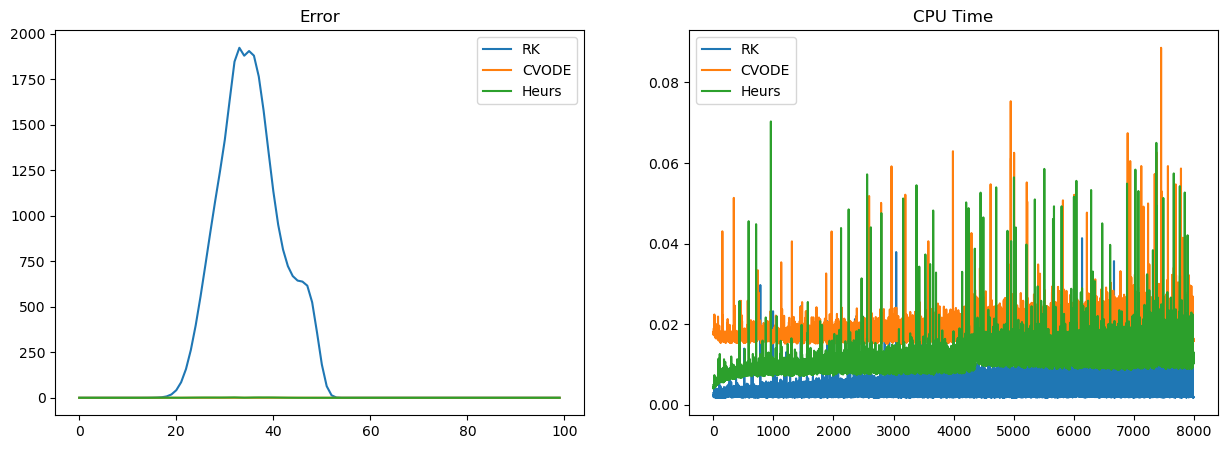

In [71]:
time_step = 5900
rk_error = rk_errors[time_step]
cvode_error = cvode_errors[time_step]
heurs_error = heurs_errors[time_step]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(rk_error, label='RK')
ax[0].plot(cvode_error, label='CVODE')
ax[0].plot(heurs_error, label='Heurs')
ax[0].set_title('Error')
ax[0].legend()
ax[1].plot(rk_cpu_times, label='RK')
ax[1].plot(cvode_cpu_times, label='CVODE')
ax[1].plot(heurs_cpu_times, label='Heurs')
ax[1].set_title('CPU Time')
ax[1].legend()
plt.show()


/var/folders/0c/k7ymw65d2fbf_9503y8nvm680000gn/T/ipykernel_68987/627026562.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


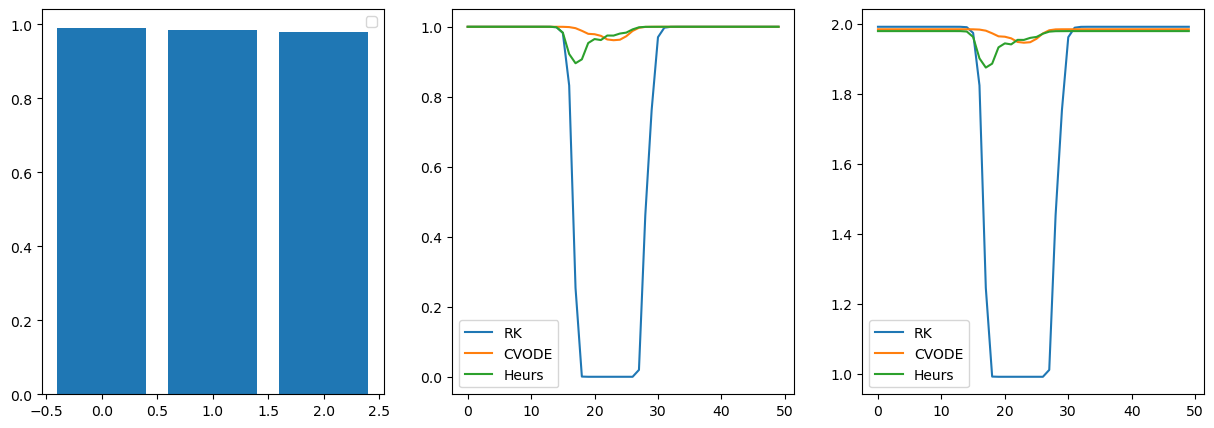

In [13]:
time_step = 100
rk_error = rk_errors[time_step]
cvode_error = cvode_errors[time_step]
heurs_error = heurs_errors[time_step]

scaling = {'error': 1.0, 'time': 0.01}
thresholds = {'error': 1, 'time': 0.005}

m_rk_error = np.exp(-scaling['error'] * rk_error / thresholds['error']) #- np.log1p(rk_error)
m_cvode_error = np.exp(-scaling['error'] * cvode_error / thresholds['error']) #-np.log1p(cvode_error)
m_heurs_error = np.exp(-scaling['error'] * heurs_error / thresholds['error']) #-np.log1p(heurs_error)

rk_cpu_time = np.exp(-scaling['time'] * rk_cpu_times[time_step] / thresholds['time'])
cvode_cpu_time = np.exp(-scaling['time'] * cvode_cpu_times[time_step] / thresholds['time'])
heurs_cpu_time = np.exp(-scaling['time'] * heurs_cpu_times[time_step] / thresholds['time'])

rw = 1
ew =  1
rk_reward = m_rk_error * ew + rk_cpu_time * rw
cvode_reward = m_cvode_error * ew + cvode_cpu_time * rw
heurs_reward = m_heurs_error * ew + heurs_cpu_time * rw

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].bar([0, 1, 2], [rk_cpu_time, cvode_cpu_time, heurs_cpu_time])
ax[1].plot(m_rk_error, label='RK')
ax[1].plot(m_cvode_error, label='CVODE')
ax[1].plot(m_heurs_error, label='Heurs')
ax[0].legend()
ax[1].legend()
ax[2].plot(rk_reward, label='RK')
ax[2].plot(cvode_reward, label='CVODE')
ax[2].plot(heurs_reward, label='Heurs')
ax[2].legend()
plt.show()

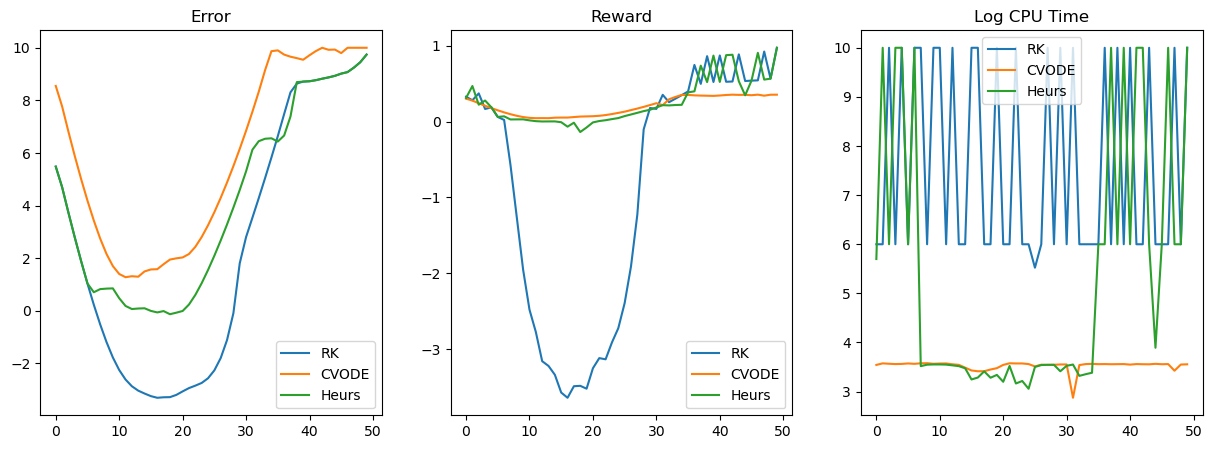

In [95]:
time_step = -1
rk_error = rk_errors[time_step]
cvode_error = cvode_errors[time_step]
heurs_error = heurs_errors[time_step]



mm_rk_error = -np.log10(np.maximum(rk_error, 1e-10))
mm_cvode_error = -np.log10(np.maximum(cvode_error, 1e-10))
mm_heurs_error = -np.log10(np.maximum(heurs_error, 1e-10))

rk_cpu_time = rk_cpu_times[time_step]
cvode_cpu_time = cvode_cpu_times[time_step]
heurs_cpu_time = heurs_cpu_times[time_step]

mm_rk_cpu_time = ( -np.log10(np.maximum(rk_cpu_time, 1e-10)))**1
mm_cvode_cpu_time = ( -np.log10(np.maximum(cvode_cpu_time, 1e-10)))**1
mm_heurs_cpu_time = ( -np.log10(np.maximum(heurs_cpu_time, 1e-10)))**1

# print(rk_cpu_time, cvode_cpu_time, heurs_cpu_time)
# print(mm_rk_cpu_time, mm_cvode_cpu_time, mm_heurs_cpu_time)


rk_reward = mm_rk_error * mm_rk_cpu_time * 0.01 - np.maximum(0, np.log10(np.maximum(rk_error, 1e-10)))
cvode_reward = mm_cvode_error * mm_cvode_cpu_time * 0.01 - np.maximum(0, np.log10(np.maximum(cvode_error, 1e-10)))
heurs_reward = mm_heurs_error * mm_heurs_cpu_time * 0.01 - np.maximum(0, np.log10(np.maximum(heurs_error, 1e-10)))


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(mm_rk_error, label='RK')
ax[0].plot(mm_cvode_error, label='CVODE')
ax[0].plot(mm_heurs_error, label='Heurs')
ax[0].legend()
ax[0].set_title('Error')
ax[1].plot(rk_reward, label='RK')
ax[1].plot(cvode_reward, label='CVODE')
ax[1].plot(heurs_reward, label='Heurs')
ax[1].legend()
ax[1].set_title('Reward')
ax[2].plot(-np.log10(np.maximum(rk_cpu_time, 1e-10)), label='RK')
ax[2].plot(-np.log10(np.maximum(cvode_cpu_time, 1e-10)), label='CVODE')
ax[2].plot(-np.log10(np.maximum(heurs_cpu_time, 1e-10)), label='Heurs')
ax[2].legend()
ax[2].set_title('Log CPU Time')
plt.show()

In [85]:
def _compute_point_reward(point_idx: int, cpu_time: float, 
                        T_error: float,reward_config: dict) -> float:
    """
    Compute reward for a specific point with better scaling and stability
    
    Returns:
        float: Reward value between -1 and 1
    """
    weights =   reward_config['weights']
    thresholds = reward_config['thresholds']
    scaling = reward_config['scaling']
    
    # Compute normalized errors (between 0 and 1)
    norm_T_error = np.minimum(1.0, T_error / thresholds['error'])
    # norm_species_errors = np.minimum(1.0, 
    #     np.mean([error / thresholds['error'] for error in species_errors.values()]))
    # norm_grad_error = np.minimum(1.0, grad_error / thresholds['error'])
    
    # Combined error metric (0 = no error, 1 = max error)
    total_error = norm_T_error
    
    # Accuracy reward component (-1 to 1)
    accuracy_reward = weights['accuracy'] * (2 * np.exp(-scaling['error'] * total_error) - 1)
    
    # Normalize CPU time (0 to 1)
    norm_time = np.minimum(1.0, cpu_time / thresholds['time'])
    
    # Efficiency reward component (-1 to 1) 
    efficiency_reward = weights['efficiency'] * (2 * np.exp(-scaling['time'] * norm_time) - 1)
    
    # Combine rewards
    reward = accuracy_reward + efficiency_reward
    
    # # Add stability penalty for very large errors
    # if total_error > 0.8:  # Only penalize severe errors
    #     stability_penalty = -weights['stability'] * (total_error - 0.8) * 5
    #     reward += stability_penalty
    
    return reward

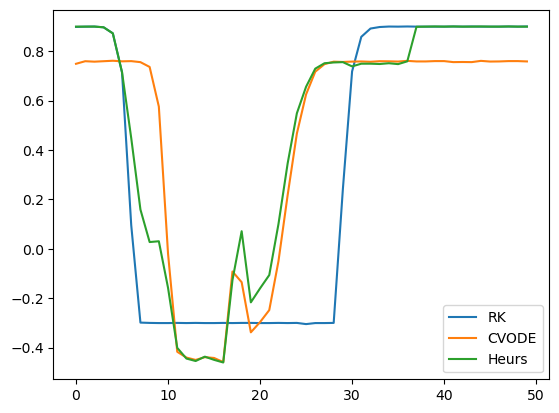

In [86]:
reward_config = {
            'weights': {
                'accuracy': 0.6,
                'efficiency': 0.3,
                'stability': 0.1
            },
            'thresholds': {
                'time': 0.005,
                'error': 1
            },
            'scaling': {
                'time': 5,
                'error': 10
            }
        }

rk_reward = _compute_point_reward(0, rk_cpu_times[time_step], rk_errors[time_step], reward_config)
cvode_reward = _compute_point_reward(0, cvode_cpu_times[time_step], cvode_errors[time_step], reward_config)
heurs_reward = _compute_point_reward(0, heurs_cpu_times[time_step], heurs_errors[time_step], reward_config)
plt.plot(rk_reward, label='RK')
plt.plot(cvode_reward, label='CVODE')
plt.plot(heurs_reward, label='Heurs')
plt.legend()
plt.show()

SUM RK: 5.371670816274338
SUM CVODE: 47.129930908475636
SUM HEURS: 48.24319518086567


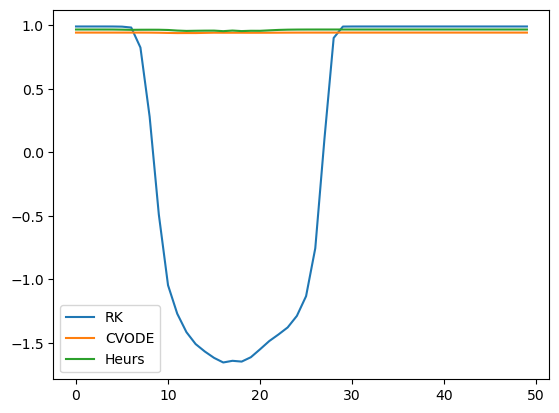

In [97]:

import numpy as np

def solver_reward(error, cpu_time,
                 # The scalings determine how sharply the exponent decays
                 error_scaling=1.0,  
                 time_scaling=0.01,
                 # "Thresholds" give a reference scale for error/time
                 error_threshold=1.0, 
                 time_threshold=0.005,
                 # Weights let you favor error vs time in the final sum
                 w_e=1.0,
                 w_t=1.0):
    """
    Returns a reward where large 'error' and large 'cpu_time' 
    both reduce the score. 'error_scaling'/'time_scaling' 
    make the penalty stronger/weaker. 'w_e'/'w_t' let you 
    trade off how strongly you value accuracy vs speed.
    """
    
    error = np.array(error)
    cpu_time = np.array(cpu_time)
    # Exponential decay for error
    # -> near 1.0 if error << error_threshold
    # -> near 0.0 if error >> error_threshold
    error_term = np.exp(-error_scaling * (error / error_threshold))
    
    # Exponential decay for time
    # -> near 1.0 if cpu_time << time_threshold
    # -> near 0.0 if cpu_time >> time_threshold
    time_term = np.exp(-time_scaling * (cpu_time / time_threshold))

    # Weighted sum to combine
    # You can also try a product:
    reward = (error_term**w_e) * (time_term**w_t)
    # if you want to “require” both low error AND low time simultaneously.
    # reward = w_e * error_term + w_t * time_term
    
    return reward - np.maximum(0, np.log10(np.maximum(error, 1e-10))/2)

time_step = 1
error_scaling = 1e2
time_scaling = 1e-2
error_threshold = 1e3
time_threshold = 1e-3
w_e = 0.3
w_t = 0.7
rk_reward = solver_reward(rk_error, rk_cpu_times[time_step], error_scaling=error_scaling, time_scaling=time_scaling, error_threshold=error_threshold, time_threshold=time_threshold, w_e=w_e, w_t=w_t)
cvode_reward = solver_reward(cvode_error, cvode_cpu_times[time_step], error_scaling=error_scaling, time_scaling=time_scaling, error_threshold=error_threshold, time_threshold=time_threshold, w_e=w_e, w_t=w_t)
heurs_reward = solver_reward(heurs_error, heurs_cpu_times[time_step], error_scaling=error_scaling, time_scaling=time_scaling, error_threshold=error_threshold, time_threshold=time_threshold, w_e=w_e, w_t=w_t)


print(f"SUM RK: {np.sum(rk_reward)}")
print(f"SUM CVODE: {np.sum(cvode_reward)}")
print(f"SUM HEURS: {np.sum(heurs_reward)}")

plt.plot(rk_reward, label='RK')
plt.plot(cvode_reward, label='CVODE')
plt.plot(heurs_reward, label='Heurs')
plt.legend()
plt.show()

In [72]:
rk_reward

array([4.43936852, 4.07506334, 3.58590235, 3.06385398, 2.49773963,
       1.85999179, 1.06920481,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 2.06352399,
       2.65564635, 3.08146323, 3.47894666, 3.85840469, 4.2238362 ,
       4.57814178, 4.92469291, 5.27503163, 5.54497717, 5.64019321,
       5.65506486, 5.65751039, 5.6715224 , 5.68861639, 5.70845678,
       5.75000593, 5.75835692, 5.81718917, 5.89348372, 6.00066487])

In [ ]:
-np.log10(cpu_time)/10

In [ ]:
weights['efficiency'] * np.exp(-scaling['time'] * cpu_time / thresholds['time'])

In [ ]:
T_es = np.array(T_errors)

logTes = -np.log10(np.maximum(T_es, 1e-10))/10
plt.plot(logTes)
plt.show()

In [ ]:
species_errors.keys()

In [82]:
err = species_errors['CH4']

In [ ]:
err

In [ ]:
logEs = -np.log10(np.maximum(err, 1e-10))/10
plt.plot(logEs)
plt.show()

In [53]:
weights = env.reward_config['weights']
thresholds = env.reward_config['thresholds']
scaling = env.reward_config['scaling']

# Accuracy reward
temp_reward = np.exp(-scaling['error'] * np.array(T_errors) / thresholds['error'])

In [ ]:
species_errors

In [ ]:
species_reward = np.mean([
    np.exp(-scaling['error'] * error / thresholds['error'])
    for error in species_errors.values()
])

In [ ]:
plt.plot(temp_reward)
plt.show()

In [49]:

species_reward = np.mean([
    np.exp(-scaling['error'] * error / thresholds['error'])
    for error in species_errors.values()
])
grad_reward = np.exp(-scaling['error'] * grad_error / thresholds['error'])

accuracy_reward = weights['accuracy'] * (temp_reward + species_reward + grad_reward) / 3

# Efficiency reward
time_reward = weights['efficiency'] * np.exp(-scaling['time'] * info['cpu_time'] / thresholds['time'])

In [ ]:
accuracy_reward

In [ ]:
import numpy as np

def calculate_reward(cpu_time, error, time_weight=0.4):
    """
    Calculate reward score for an integration method based on CPU time and error.
    Uses dynamic normalization that doesn't require knowing global min/max values.
    
    Parameters:
    -----------
    cpu_time : float
        CPU time taken by the integrator
    error : float
        Error of the integration result
    time_weight : float, optional (default=0.4)
        Weight for the CPU time component (0 to 1)
        Error weight will be (1 - time_weight)
    
    Returns:
    --------
    float
        Reward score (higher is better)
    """
    # Prevent division by zero or negative values
    cpu_time = max(cpu_time, 1e-10)
    error = max(error, 1e-10)
    
    # Transform CPU time using negative exponential
    # This makes smaller times exponentially better
    # and naturally bounds the score between 0 and 1
    time_score = np.exp(-cpu_time / 0.05)  # 0.01 is a scaling factor
    
    # Transform error similarly with appropriate scaling
    # Using a different scale for error since it has a different range
    error_score = np.exp(-error / 100.0)  # 10.0 is a scaling factor
    
    # Combine scores with weights
    final_score = (time_weight * time_score + 
                  (1 - time_weight) * error_score)
    
    return final_score

def test_reward_function():
    # Test data
    test_cases = [
        # (cpu_time, error)
        (0.001687765121459961, 0.1),  # Very fast, good accuracy
        (0.09123587608337402, 0.1),   # Slow, good accuracy
        (0.001687765121459961, 100),  # Very fast, poor accuracy
        (0.09123587608337402, 100),   # Slow, poor accuracy
        (0.01, 1.0),                  # Medium case
    ]
    
    print("Testing reward function with various cases:")
    for time, error in test_cases:
        score = calculate_reward(time, error)
        print(f"Time: {time:.6f}, Error: {error:.6f}, Score: {score:.6f}")
    
    # Test with your example data
    integrators = {
        'RK': {
            'time': {'mean': 0.0023427907154839707},
            'error': {'mean': 195.61464013288054}
        },
        'Heurs': {
            'time': {'mean': 0.009025832598553387},
            'error': {'mean': 0.23173495163231658}
        },
        'CVODE': {
            'time': {'mean': 0.01673633445945791},
            'error': {'mean': 0.08525023770717294}
        }
    }
    
    print("\nReward scores using mean values from your data:")
    for method, data in integrators.items():
        score = calculate_reward(data['time']['mean'], data['error']['mean'])
        print(f"{method}: {score:.6f}")

if __name__ == "__main__":
    test_reward_function()

In [ ]:
len(rk_errors)

In [ ]:
rk_rewardss = []
cvode_rewardss = []
heurs_rewardss = []
for point in range(100):
    rk_reward = calculate_reward(rk_cpu_times[point], rk_errors[1000][point])
    cvode_reward = calculate_reward(cvode_cpu_times[point], cvode_errors[1000][point])
    heurs_reward = calculate_reward(heurs_cpu_times[point], heurs_errors[1000][point])
    rk_rewardss.append(rk_reward)
    cvode_rewardss.append(cvode_reward)
    heurs_rewardss.append(heurs_reward)
plt.plot(rk_rewardss, label='RK')
plt.plot(cvode_rewardss, label='CVODE')
plt.plot(heurs_rewardss, label='Heurs')
plt.legend()
plt.show()

In [9]:
def _compute_point_reward(point_idx: int, cpu_time: float, 
                            T_error: float, species_errors: dict, grad_error: float,
                            neighbor_radius: int = 2, reward_config: dict = None) -> float:
        """
        Compute reward for a specific point considering neighbor influence
        
        Args:
            point_idx: Index of the current point
            cpu_time: Computation time for the step
            T_error: Temperature error at the point
            species_errors: Dictionary of species errors
            grad_error: Gradient error at the point
            neighbor_radius: Number of neighboring points to consider on each side
            
        Returns:
            float: Reward value between -1 and 1
        """
        weights = reward_config['weights']
        thresholds = reward_config['thresholds']
        scaling = reward_config['scaling']
        
        # Get neighboring points indices
        n_points = env.sim_settings.n_points
        start_idx = max(0, point_idx - neighbor_radius)
        end_idx = min(n_points, point_idx + neighbor_radius + 1)
        neighbor_indices = list(range(start_idx, end_idx))
        
        # Compute local errors for current point
        norm_T_error = np.minimum(1.0, T_error / thresholds['error'])
        norm_species_errors = np.minimum(1.0, 
            np.mean([error / thresholds['error'] for error in species_errors.values()]))
        norm_grad_error = np.minimum(1.0, grad_error / thresholds['error'])
        
        # Combined error metric for current point (0 = no error, 1 = max error)
        point_error = (norm_T_error + norm_species_errors + norm_grad_error) / 3
        
        # Calculate neighbor errors and weights
        neighbor_errors = []
        neighbor_weights = []
        
        for idx in neighbor_indices:
            if idx != point_idx:  # Skip the current point
                T_err, spec_err, grad_err = env._calculate_point_error(idx)
                norm_T = np.minimum(1.0, T_err / thresholds['error'])
                norm_spec = np.minimum(1.0, 
                    np.mean([err / thresholds['error'] for err in spec_err.values()]))
                norm_grad = np.minimum(1.0, grad_err / thresholds['error'])
                total_err = (norm_T + norm_spec + norm_grad) / 3
                neighbor_errors.append(total_err)
                
                # Calculate distance-based weight
                distance = abs(idx - point_idx)
                weight = np.exp(-distance / neighbor_radius)
                neighbor_weights.append(weight)
        
        # Convert to numpy arrays
        neighbor_errors = np.array(neighbor_errors)
        neighbor_weights = np.array(neighbor_weights)
        
        # Normalize weights to sum to 1
        if len(neighbor_weights) > 0:
            neighbor_weights = neighbor_weights / np.sum(neighbor_weights)
            neighbor_error = np.sum(neighbor_errors * neighbor_weights)
        else:
            neighbor_error = point_error  # If no neighbors, use point error
        
        # Combine local and neighbor errors
        neighbor_influence = 0.3  # Parameter to control neighbor influence strength
        total_error = (1 - neighbor_influence) * point_error + neighbor_influence * neighbor_error
        
        # Accuracy reward component (-1 to 1)
        accuracy_reward = weights['accuracy'] * (2 * np.exp(-scaling['error'] * total_error) - 1)
        
        # Normalize CPU time (0 to 1)
        norm_time = np.minimum(1.0, cpu_time / thresholds['time'])
        
        # Efficiency reward component (-1 to 1) 
        efficiency_reward = weights['efficiency'] * (2 * np.exp(-scaling['time'] * norm_time) - 1)
        
        # Combine rewards
        reward = accuracy_reward + efficiency_reward
        
        # Add stability penalty for very large errors
        if total_error > 0.8:  # Only penalize severe errors
            stability_penalty = -weights['stability'] * (total_error - 0.8) * 5
            reward += stability_penalty
        
        # Add coupling penalty if point's error is significantly different from neighbors
        if len(neighbor_errors) > 0:
            error_deviation = abs(point_error - neighbor_error)
            if error_deviation > 0.2:  # Threshold for significant deviation
                coupling_penalty = -0.2 * error_deviation
                reward += coupling_penalty
        
        return reward

In [8]:
reward_config = {
            'weights': {
                'accuracy': 1,
                'efficiency': 3,
            },
            'thresholds': {
                'time': 0.001,
                'error': 1
            },
            'scaling': {
                'time': 1,
                'error': 1
            }
        }